In [3]:
#%matplotlib qt
import hyperspy.api as hs

#import matplotlib.pyplot as plt
import numpy as np
from pathlib import *



import skimage.segmentation as seg
from skimage import filters
from skimage import (
    data, restoration, util
)
from skimage import io
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt

## A litttle setup of all the needed variables

In [94]:
be=10 # beam energy in kv

element_list=['Mg','Al','Ca','O']
line_list=['Mg_Ka','Al_Ka','Ca_Ka','O_Ka']

In [112]:

file_n=2

In [113]:
import hyperspy.signal

## Load in the edx spectrum map
- We use the hypersyp api to do so, we need the spd files and the ipr files in the folder, getting them by using path.glob

In [195]:
path=Path("/work/mz071159/edx/50_45_yolo/")
# file="map20220810083556875_0.spd"
# ipr="fov20220810083203210.ipr"
spd=list(path.glob('**/*.spd'))
ipr=list(path.glob('**/*.ipr'))
s= hs.load(spd[file_n], load_all_spc=True, ipr_fname=ipr[file_n]).as_signal2D(1)
# spec=hs.load(sopd[])
# spec

In [115]:
spd

[PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 2/map20230717084300668_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 4/map20230717094340333_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 4/map20230717094809024_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 8/map20230912092011552_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 8/map20230912091823933_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103524050_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103048304_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912102552424_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103956420_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/4mm/Area 1/map20230912110933940_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/5mm/Area 2/map20230912124524933_0.spd')]

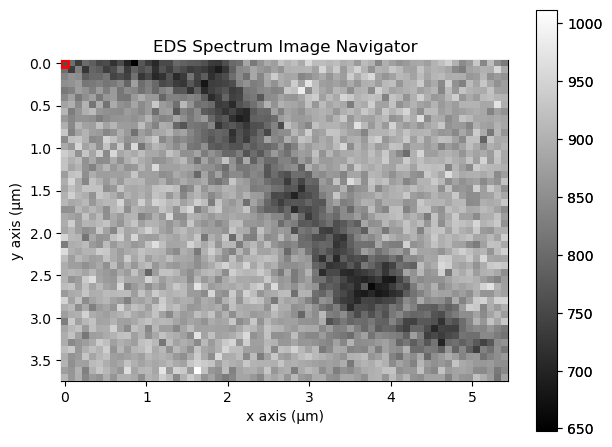

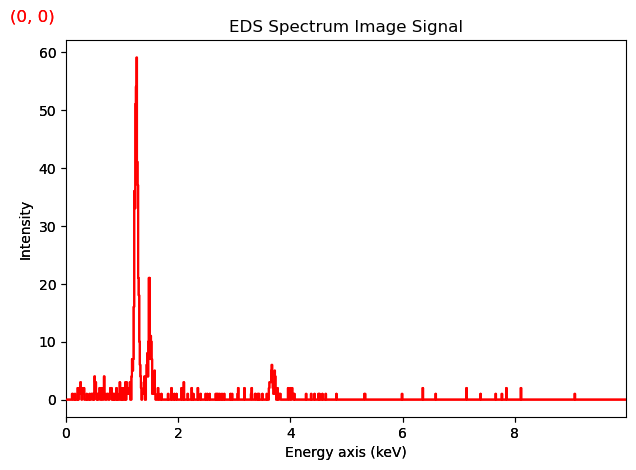

In [116]:
s.plot()

## Image Loading and thresholding
- this can be done to segment the microstructure for two phases based on the SEM signal
- we could in principle also segment on the EDX signal, or for mutliple phases, but this is not yet implemented.


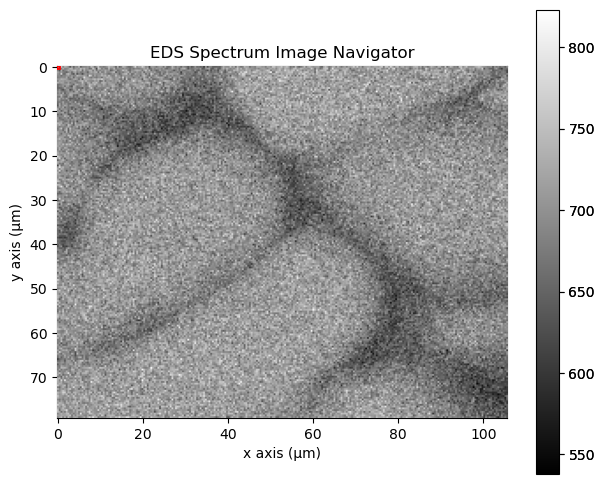

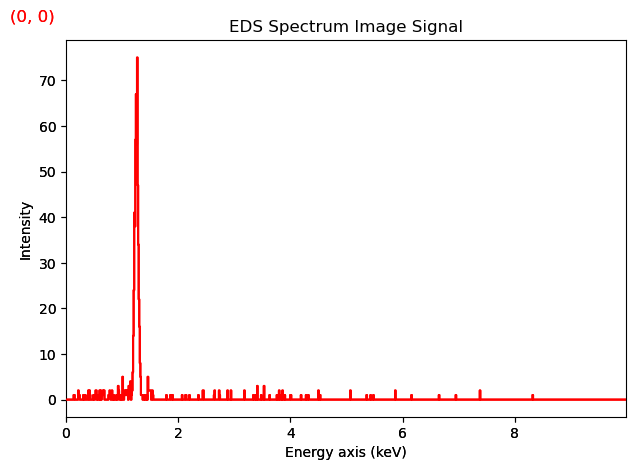

In [132]:
file_n=3
s= hs.load(spd[file_n], load_all_spc=True, ipr_fname=ipr[file_n]).as_signal2D(1)
s.plot()
# spec=hs.load(sopd[])

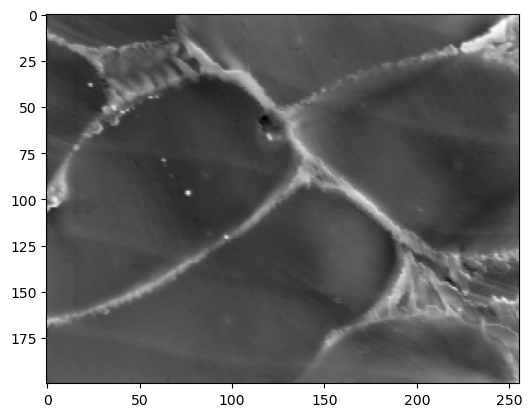

In [161]:
# img_list=list(path.glob('**/*_Img.bmp'))
img_file=spd[file_n].parent.joinpath(f'{spd[file_n].stem}_Img.bmp')
img=io.imread(img_file)
background = restoration.rolling_ball(img)
img_b_sub=img-background
plt.imshow(img,cmap='gray')

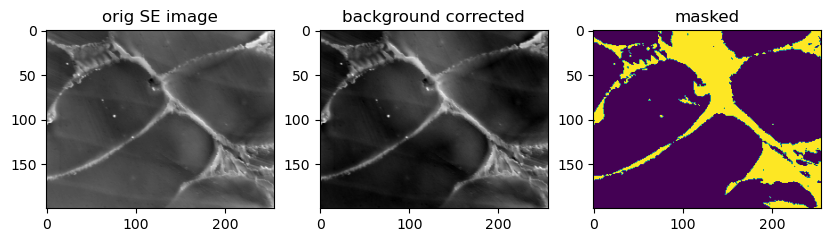

In [162]:
thresh=threshold_otsu(img_b_sub)
mask=img_b_sub>thresh
fig,ax=plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('orig SE image')
ax[1].imshow(img_b_sub,cmap='gray')
ax[1].set_title('background corrected')
ax[2].set_title('masked')
ax[2].imshow(mask)
fig.savefig(spd[0].parents[file_n].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_comparison_segmentation.png'))

In [163]:
img.shape

(200, 256)

## Apply mask on the EDS signal
- once we have segmented the EDS signal, we can apply the thus obtained mask to the EDS data and by such generate two separate signals, from which we can extract the spectrum in the end

In [164]:
s.data.shape

(200, 256, 1000)

In [165]:
shape_save=s.data.shape
data_array=s.data
mask_tiles=np.tile(mask,[shape_save[2],1,1])
# mask_tiles.shape
mask_tiles=mask_tiles.transpose(1,2,0)
data_array_masked=data_array*mask_tiles #mask and inverse mask in next row
data_array_masked2=data_array*~mask_tiles 
data_array_masked.shape


(200, 256, 1000)

In [166]:
#construct the two different signals
newsig1_inv= hyperspy._signals.eds.EDSSpectrum(data_array_masked)
newsig1_inv.set_signal_type('EDS_SEM')
newsig1_inv.original_metadata=s.original_metadata
newsig1_inv.metadata=s.metadata
newsig1_inv.axes_manager=s.axes_manager

# data_array_masked=data_array*~mask_tiles
# data_array_masked.shape
newsig2_inv= hyperspy._signals.eds.EDSSpectrum(data_array_masked2)
newsig2_inv.set_signal_type('EDS_SEM')
newsig2_inv.original_metadata=s.original_metadata
newsig2_inv.metadata=s.metadata
newsig2_inv.axes_manager=s.axes_manager


/home/mz071159/miniconda3/lib/python3.9/site-packages/hyperspy/_signals/eds.py:49: UserWarning: The microscope type is not set. Use set_signal_type('EDS_TEM')  or set_signal_type('EDS_SEM')
  warnings.warn('The microscope type is not set. Use '
/home/mz071159/miniconda3/lib/python3.9/site-packages/hyperspy/signal.py:2467: UserWarning: Setting the `original_metadata` attribute is deprecated and will be removed removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `original_metadata` attribute instead.
  warnings.warn(
/home/mz071159/miniconda3/lib/python3.9/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


In [167]:
# sum above all points to get th sum spectrum of the two regions from the map

sumsig=np.sum(newsig1_inv.data,axis=(0,1))
sumsig.shape

sumsig2=np.sum(newsig2_inv.data,axis=(0,1))
sumsig2.shape

(1000,)

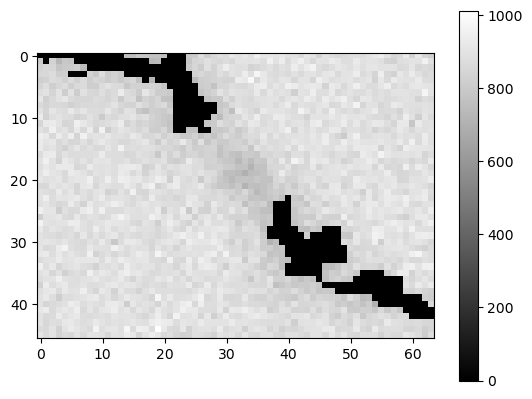

In [139]:
fig,ax=plt.subplots()
im=ax.imshow(np.sum(newsig2_inv.data,axis=(2)),cmap='gray')
fig.colorbar(im)
fig.savefig((spd[file_n].parents[1].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_counts_phase2.png')))

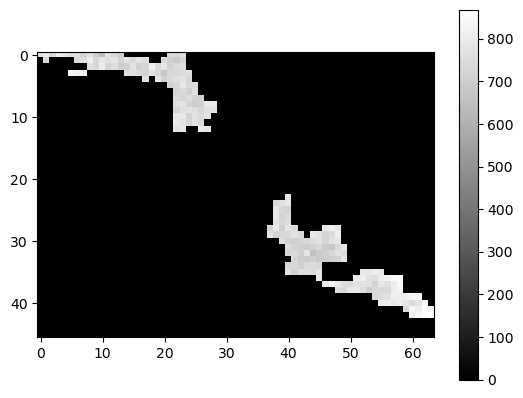

In [140]:
fig,ax=plt.subplots()
im=ax.imshow(np.sum(newsig1_inv.data,axis=(2)),cmap='gray')
fig.colorbar(im)
fig.savefig((spd[file_n].parents[1].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_counts_phase1.png')))

In [141]:
matrix=[]
matrix= hyperspy._signals.eds.EDSSpectrum(sumsig2)
matrix.set_signal_type('EDS_SEM')
matrix.original_metadata=s.original_metadata
matrix.metadata=s.metadata
matrix.axes_manager[-1].name='Energy'
matrix.axes_manager['Energy'].units=s.axes_manager['Energy'].units
matrix.axes_manager['Energy'].scale=s.axes_manager['Energy'].scale
matrix.axes_manager['Energy'].offset=s.axes_manager['Energy'].offset

matrix.set_microscope_parameters(beam_energy=10)


matrix.set_elements(['Mg','Al','Ca','O'])
# matrix.add_lines()
matrix.set_lines(['Mg_Ka','Al_Ka','Ca_Ka','O_Ka'])

In [142]:
precip=hyperspy._signals.eds.EDSSpectrum(sumsig)
precip.set_signal_type('EDS_SEM')
precip.original_metadata=s.original_metadata
precip.metadata=s.metadata
precip.axes_manager[-1].name='Energy'
precip.axes_manager['Energy'].units=s.axes_manager['Energy'].units
precip.axes_manager['Energy'].scale=s.axes_manager['Energy'].scale
precip.axes_manager['Energy'].offset=s.axes_manager['Energy'].offset
precip.set_microscope_parameters(beam_energy=be)


precip.set_elements(element_list)
# matrix.add_lines()
precip.set_lines(line_list)

In [143]:
spd

[PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 2/map20230717084300668_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 4/map20230717094340333_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/head/Area 4/map20230717094809024_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 8/map20230912092011552_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 8/map20230912091823933_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103524050_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103048304_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912102552424_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/3mm/Area 9/map20230912103956420_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/4mm/Area 1/map20230912110933940_0.spd'),
 PosixPath('/work/mz071159/edx/50_45_yolo/5mm/Area 2/map20230912124524933_0.spd')]

In [144]:
# (spd[0].parents[file_n].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_comparison_segmentation.png'))
precip.save((spd[file_n].parents[1].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_phase1.msa')))
matrix.save((spd[file_n].parents[1].joinpath(f'{spd[file_n].parent.stem}_{spd[file_n].stem}_phase2.msa')))

## Test alternative route with decomposition

In [198]:
# import numpy as np

# from hyperspy.signals import Signal1D

# s = Signal1D(np.random.randn(10, 10, 200))
s.change_dtype('float64')
s.decomposition(output_dimension=3)

# Load data from a file, then decompose

# s = hs.load("my_file.hspy")

# s.decomposition()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=3
  centre=None


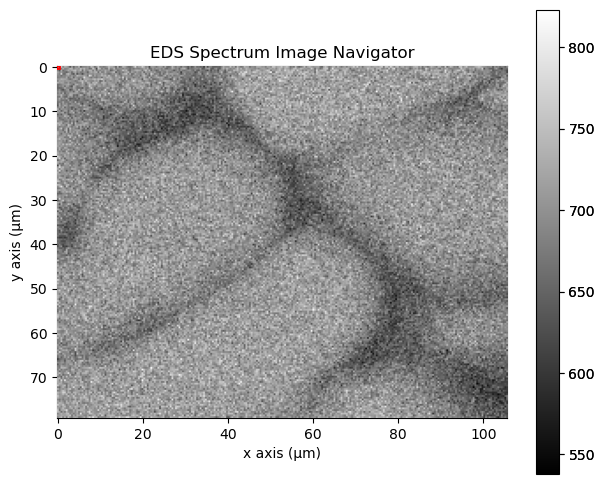

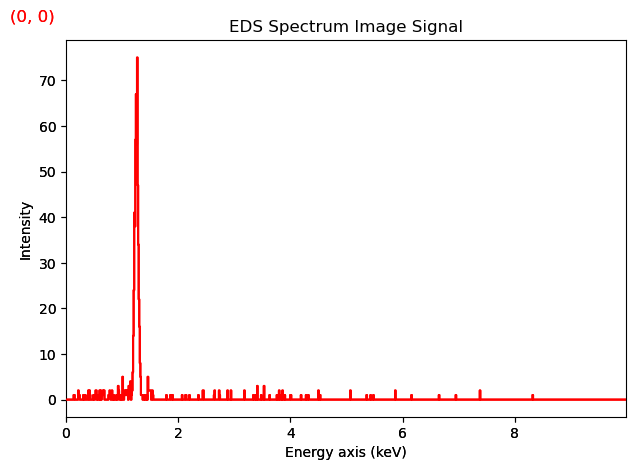

In [202]:
s.plot()

In [176]:
s.decomposition(algorithm="SVD", centre="navigation")

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=navigation


In [200]:

# ax = s.plot_explained_variance_ratio()
s.blind_source_separation(2)



[                                        ] | 0% Completed | 256.22 us

[########################################] | 100% Completed | 101.61 ms


Blind source separation info:
  number_of_components=2
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


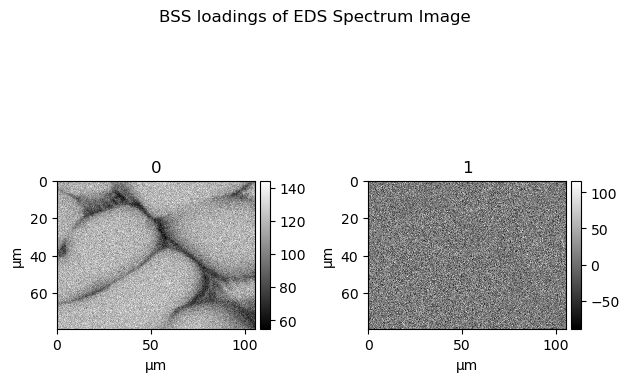

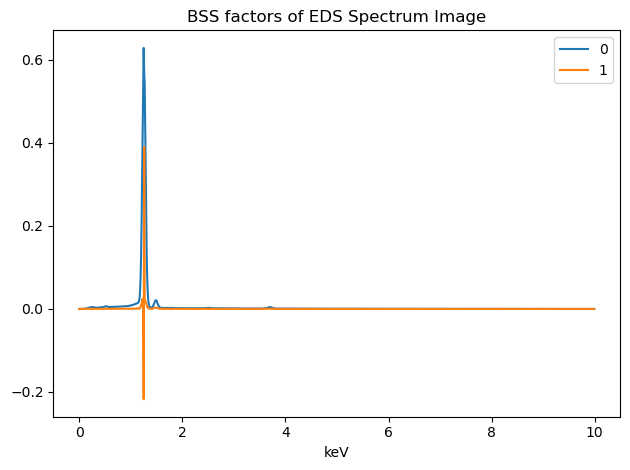

In [201]:
axes=s.plot_bss_loadings()
axes=s.plot_bss_factors()

In [191]:

s_bss=s.get_bss_factors().inav[0]

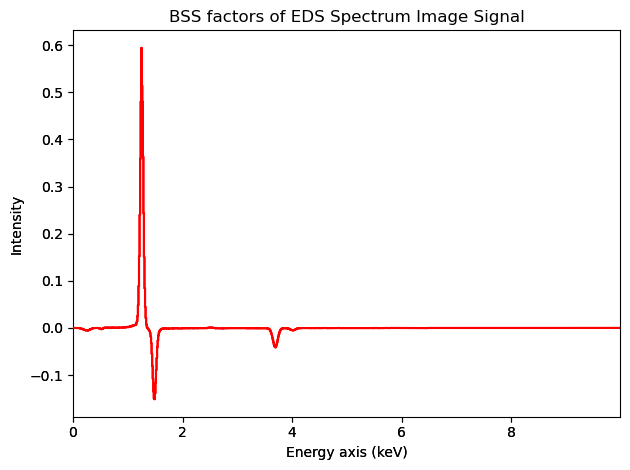

In [194]:
s_bss.plot()

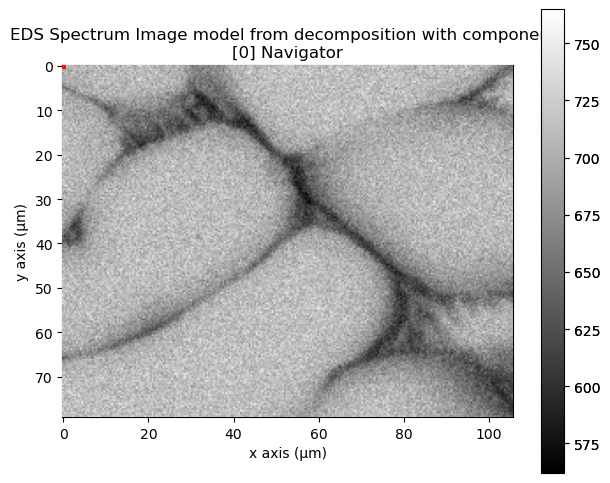

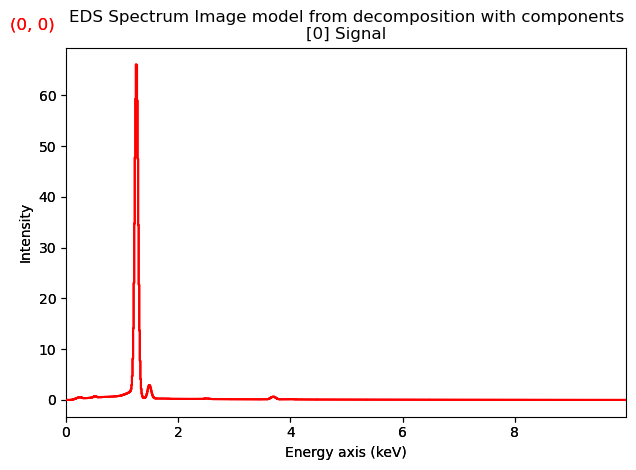

In [184]:
sc=s.get_decomposition_model([0])
sc.plot()

In [7]:
m=matrix.create_model()
m.print_current_values()

NameError: name 'matrix' is not defined

Al_Ka at 1.4865 keV : Intensity = 402484.00
Ca_Ka at 3.6917 keV : Intensity = 89862.00
Mg_Ka at 1.2536 keV : Intensity = 24839242.13
O_Ka at 0.5249 keV : Intensity = 88312.20


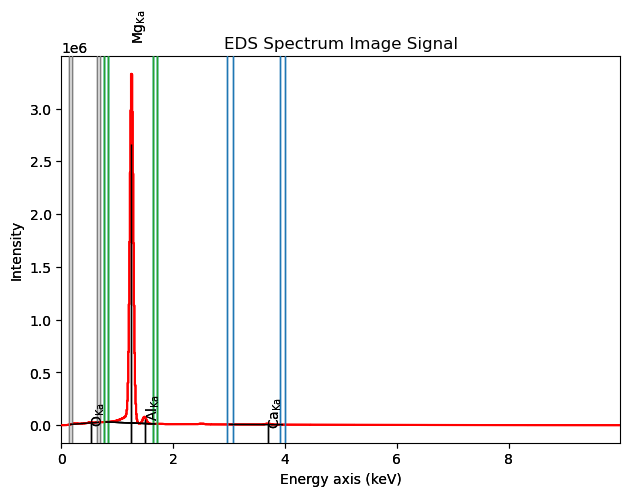

In [ ]:
bw = matrix.estimate_background_windows(line_width=[6.0, 2.0])

matrix.plot(background_windows=bw)

intensities=matrix.get_lines_intensity(background_windows=bw, plot_result=True)

In [ ]:
matrix.set_microscope_parameters(beam_energy=10)

In [ ]:
matrix.quantification(intensities, method='ZAF',composition_units='weight')

AttributeError: 'EDSSEMSpectrum' object has no attribute 'quantification'

In [ ]:
s?

Call signature: s(axes_manager=None, fft_shift=False, as_numpy=False)
Type:           EDSSEMSpectrum
String form:    <EDSSEMSpectrum, title: EDS Spectrum Image, dimensions: (256, 200|1000)>
Length:         51200
File:           ~/miniconda3/lib/python3.9/site-packages/hyperspy/_signals/eds_sem.py
Docstring:      1D signal class for EDS spectra measured in an SEM.
Init docstring:
Create a Signal from a numpy array.

Parameters
----------
data : :py:class:`numpy.ndarray`
   The signal data. It can be an array of any dimensions.
axes : [dict/axes], optional
    List of either dictionaries or axes objects to define the axes (see
    the documentation of the :py:class:`~hyperspy.axes.AxesManager`
    class for more details).
attributes : dict, optional
    A dictionary whose items are stored as attributes.
metadata : dict, optional
    A dictionary containing a set of parameters
    that will to stores in the ``metadata`` attribute.
    Some parameters might be mandatory in some cases.
orig